In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import nltk

In [2]:
df = pd.read_table("../Data/practice_data.tsv",encoding= 'unicode_escape')

# Keyword Overlap

In [3]:
# First get the dataframe of just the citing and cited tited as well as teh class label
title_df = df[["citing_title", "cited_title", "citation_class_label", "citation_influence_label"]]
title_df.head()

citing_title  \
0  Ontology-Based Recommendation of Editorial Pro...   
1  Ontology-Based Recommendation of Editorial Pro...   
2  Ontology-Based Recommendation of Editorial Pro...   
3  Ontology-Based Recommendation of Editorial Pro...   
4  Ontology-Based Recommendation of Editorial Pro...   

                                         cited_title  citation_class_label  \
0  Web search personalization with ontological us...                     5   
1             Exploring Scholarly Data with Rexplore                     0   
2  Klink-2: Integrating Multiple Web Sources to G...                     0   
3  Forecasting the Spreading of Technologies in R...                     0   
4  Supporting Springer Nature Editors by means of...                     5   

   citation_influence_label  
0                         0  
1                         0  
2                         0  
3                         1  
4                         1

In [4]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download("wordnet")
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer 
from nltk.stem import PorterStemmer 

def drop_stop_words(title):
    """Drop the core english stopwords in a title. Additionally stem and lemmatize them as well."""
    
    # Break apart hyphenated words
    hyphen_split = title.split('-')
    title = " ".join(hyphen_split)
    
    # First tokenize the input to break it into parts
    word_tokens = word_tokenize(title)
    
    # Get the set of stop words
    stop_words = set(stopwords.words('english'))
    
    # Filter and reconstruct. Also stem the words
    lemmatizer = WordNetLemmatizer()
    ps = PorterStemmer()
    filtered_sentence = [lemmatizer.lemmatize(w.lower()) for w in word_tokens if not w in stop_words]  
  
    return filtered_sentence

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\angik\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\angik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Create a new column in the dataframe to store the overlap feature
title_df["keyword_overlap"] = np.zeros(title_df.shape[0])

# Traverse through all the rows of the dataframe and generate the new feature
for row in title_df.index:
    # Grab the citing and cited title
    citing_title = title_df.iloc[row]["citing_title"]
    cited_title = title_df.iloc[row]["cited_title"]
    
    # Compute the filtered versions of both
    citing_words = drop_stop_words(citing_title)
    cited_words = drop_stop_words(cited_title)
    
    # Count the overlap
    overlap = len(set(citing_words) & set(cited_words)) 
    title_df.loc[row,"keyword_overlap"] = overlap

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# Number of verbs + Verb Tense

In [6]:
def count_verbs(context):
    """Given a citation context, break it into words and return the number of verbs."""
    
    context_words = word_tokenize(context)
    tags = nltk.pos_tag(context_words)
    verb_count = 0
    for tag in tags:
        if "VB" in tag[1]:
            verb_count += 1
    
    return verb_count

In [7]:
# Create a new column in the dataframe to store the num verbs feature
df["num_verbs"] = np.zeros(title_df.shape[0])

# Traverse through all the rows of the dataframe and generate the new feature
for row in title_df.index:
    # Grab the citation context
    context = df.iloc[row]["citation_context"]
    
    # Compute the verb count
    verb_count = count_verbs(context)
    
    # Count the overlap
    df.at[row,"num_verbs"] = verb_count

In [8]:
def count_verbs_tense(context, tense):
    """Given a citation context, break it into words and return the number of verbs."""
    
    context_words = word_tokenize(context)
    tags = nltk.pos_tag(context_words)
    verb_count = 0
    for tag in tags:
        if tense in tag[1]:
            verb_count += 1
    
    return verb_count

In [9]:
tenses = ["VB","VBZ", "VBG", "VBN", "VBD"]
for tense in tenses:
    # Create feature
    feature_name = f"num_verbs_{tense}"
    df[feature_name] = np.zeros(df.shape[0])

    # Traverse through all the rows of the dataframe and generate the new feature
    for row in df.index:
        # Grab the citation context
        context = df.iloc[row]["citation_context"]

        # Compute the verb count
        verb_count = count_verbs_tense(context, tense)

        # Count the overlap
        df.at[row,feature_name] = verb_count

# Structural features

In [10]:
df['citation_rel_loc'] = (df['citation_context'].str.index("#AUTHOR_TAG")) / (df['citation_context'].str.len() - 11)

In [11]:
citation_rel_punc = []
for i in range(len(df)):
    text = df['citation_context'].iloc[i]
    ind = text.index('#AUTHOR_TAG')
    val = -1
    start = 0
    end = len(text) - 1
    for j in range(ind, 0, -1):
        if text[j] == ',' or text[j] == '.' or text[j] == ';':
            start = j
            break
    for j in range(ind, len(text)):
        if text[j] == ',' or text[j] == '.' or text[j] == ';':
            end = j
            break
    end -= 10
    val = (ind - start) / (end - start)
    citation_rel_punc.append(val)

df['citation_rel_punc'] = citation_rel_punc

In [12]:
df['citation_len'] = df['citation_context'].str.split().str.len() - 1 # -1 for #AUTHOR_TAG

In [13]:
df['num_citations'] = df['citation_context'].str.count('\[') - df['citation_context'].str.count('\[#AUTHOR_TAG\]')

In [14]:
citation_in_paren = []
for i in range(len(df)):
    text = df['citation_context'].iloc[i]
    ind = text.index('#AUTHOR_TAG')
    flag = 0
    for j in range(ind, len(text)):
        if text[j] == ')':
            for k in range(j, 0, -1):
                if text[k] == '(':
                    if ind > k and ind < j:
                        flag = 1
    citation_in_paren.append(flag)

df['citation_in_paren'] = citation_in_paren

In [15]:
active_verb = []
for i in range(len(df)):
    text = nltk.word_tokenize(df['citation_context'].iloc[i])
    pos_tagged = nltk.pos_tag(text)
    for s in [y[0] for y in pos_tagged]:
        if 'AUTHOR_TAG' in s:
            index = [y[0] for y in pos_tagged].index(s)
            break
    if index != len(pos_tagged) - 1 and 'VB' in pos_tagged[index + 1][1]:
        active_verb.append(1)
    else:
        active_verb.append(0)
        
df['active_verb'] = active_verb

In [16]:
desc = []
for i in range(len(df)):
    text = df['citation_context'].iloc[i]
    ind = text.index('#AUTHOR_TAG')
    flag = 0
    for j in range(ind, len(text)):
        if text[j] == ',':
            if text[j + 2] == 'a':
                flag = 1
            break
    desc.append(flag)

df['citation_description'] = desc

# Sentence Pattern

In [20]:
from getSentencePattern import get_custom_pattern_features_wrapper, countCases

sent_pat_feature = df['citation_context'].apply(get_custom_pattern_features_wrapper)

Exception: Check whether you have started the CoreNLP server e.g.
$ cd stanford-corenlp-full-2015-12-09/ 
$ java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer

In [21]:
types = ['Background', 'CompareOrContrast', 'Prior', 'Future', 'Motivation', 'Uses']

for i in range(len(types)):
    # Convert each feature into a number (count the cases)
    score = sent_pat_feature.apply(countCases, args=(types[i], ))
    feature_name = f"sentence_pattern_{types[i]}"
    df[feature_name] = score

NameError: name 'sent_pat_feature' is not defined

# Stop Word Embedding

In [22]:
df["tokens"] = [word_tokenize(context.replace("#AUTHOR_TAG", "")) for context in df["citation_context"]]


threshold = 3 #frequency threshold for throwing out words

tokenized_corpus = []
[tokenized_corpus.extend(word_tokenize(context.replace("#AUTHOR_TAG", ""))) for context in df["citation_context"]]
fdist = nltk.FreqDist(tokenized_corpus)
fdftotal = pd.DataFrame(fdist.items(), columns = ['word', 'freq'])
fdf = fdftotal.loc[fdftotal.freq > threshold]

In [24]:
glovepath = "../Utilties/glove"
embeddings_dict = {}
with open(glovepath + "/glove.6B.50d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [25]:
#Generate embeddings out of tokenized sentences
def embed_context(tokens, fdf):
    vector = []
    for word in tokens:
        if word in fdf["word"].values and word in embeddings_dict:
            vector.append(embeddings_dict[word])
    return np.sum(vector, axis=0)

X = np.array([embed_context(tokens, fdf) for tokens in df["tokens"]])

In [26]:
temp = []
for i in range(len(X)):
    t = tuple(X[i])
    temp.append(t)

# Concatenate features

In [32]:
df['embedding'] = list(zip(df.num_verbs, df.num_verbs_VB, df.num_verbs_VBD, 
                           df.num_verbs_VBN, df.num_verbs_VBG, df.num_verbs_VBZ, df.citation_rel_loc,
                           df.citation_rel_punc, df.citation_len, df.num_citations, df.citation_in_paren,
                           df.active_verb, df.citation_description))
#df.sentence_pattern_Background,
#df.sentence_pattern_CompareOrContrast, df.sentence_pattern_Motivation, df.sentence_pattern_Uses))
#Not working for some reason
#  keyword_overlap, df.sentence_pattern_Prior, and df.sentence_pattern_Future are all array of 0's.
embed = []
for i in range(len(df)):
    t = df['embedding'].iloc[i] + temp[i]
    embed.append(t)
    
# Normalize features
temp1 = pd.DataFrame(np.array(embed))
for c in temp1.columns:
    if temp1[c].max() == temp1[c].min():
        print(c)
    temp1[c] = (temp1[c] - temp1[c].min()) / (temp1[c].max() - temp1[c].min())

e1 = list(map(tuple, np.array(temp1)))

df['embedding'] = e1

In [33]:
df['embedding'].head()

0    (0.09523809523809523, 0.09523809523809523, 0.0...
1    (0.2857142857142857, 0.2857142857142857, 0.333...
2    (0.23809523809523808, 0.23809523809523808, 0.1...
3    (0.38095238095238093, 0.38095238095238093, 0.2...
4    (0.3333333333333333, 0.3333333333333333, 0.0, ...
Name: embedding, dtype: object

# Train basic models

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

# ROC with a model (vector feature)
def rocm(X, y, model, title = "Influence Label"):
    # generate 2 class dataset
    X = np.array([*X])
    # split into train/test sets
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
    # fit a model
    model.fit(trainX, trainy)
    # predict probabilities
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    print('Logistic: ROC AUC=%.3f' % (lr_auc))

    # plot the roc curve for the model
    fpr, tpr, thresholds = roc_curve(testy, lr_probs)

    # Plot the curve
    plt.figure(figsize = (10,6))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.plot(fpr, tpr, linestyle = "--", marker = ".",  markersize = 15)
    plt.plot([0,1],[0,1], linestyle = "--", c = "k")
    plt.show()
    
def mmrocm(X, y, model):
    for i in range(6):
        y_i = []
        for j in range(len(y)):
            if y.iloc[j] != i:
                y_i.append(0)
            else:
                y_i.append(1)
        title = "Class Label {}".format(i)
        rocm(X, y_i, model, title)
        
def eval_inf(X, y, model):
    X = np.array([*X])
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
    model.fit(trainX, trainy)
    predy = model.predict(testX)
    score = f1_score(testy, predy)
    print("Influence F1 score: {}".format(score))
    
def eval_class(X, y, model):
    X = np.array([*X])
    trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=2)
    model.fit(trainX, trainy)
    predy = model.predict(testX)
    score = f1_score(testy, predy, average = 'macro')
    print("Class F1 score: {}".format(score))

### Logistic Regression

Logistic: ROC AUC=0.620


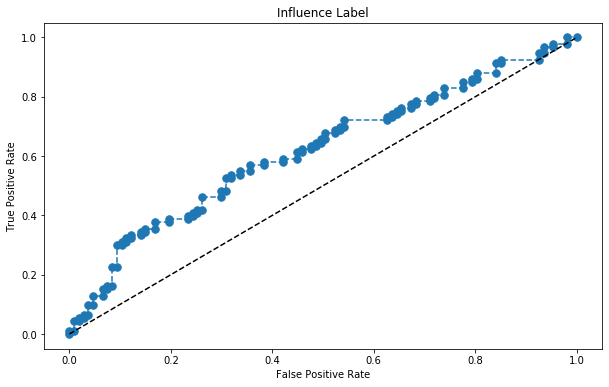

Logistic: ROC AUC=0.726


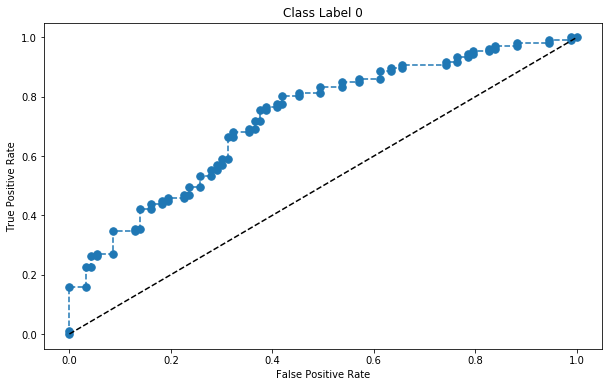

Logistic: ROC AUC=0.703


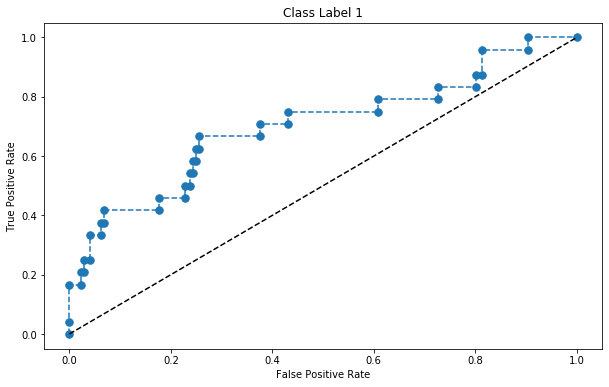

Logistic: ROC AUC=0.648


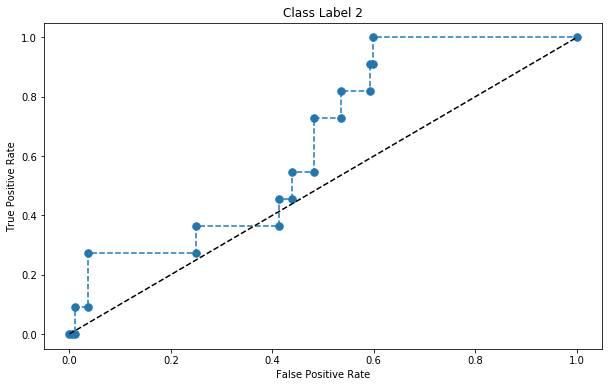

Logistic: ROC AUC=0.344


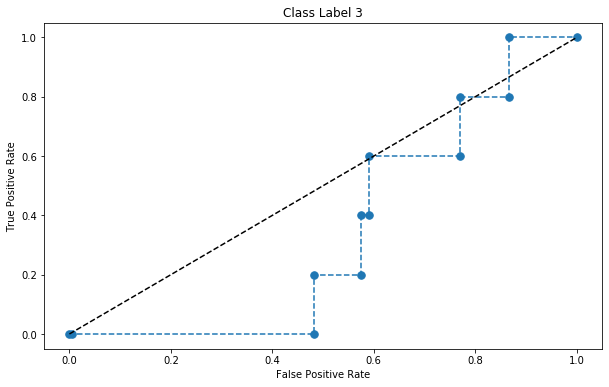

Logistic: ROC AUC=0.597


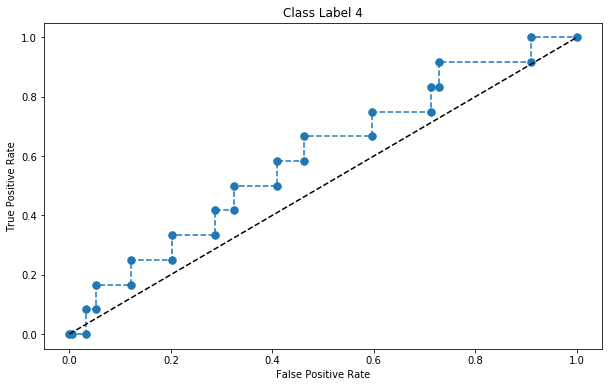

Logistic: ROC AUC=0.738


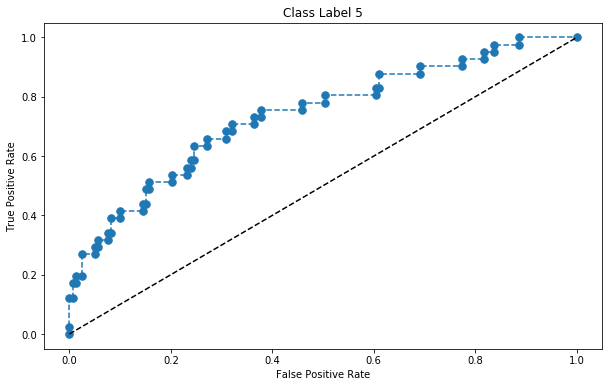

Influence F1 score: 0.4768211920529801
Class F1 score: 0.18366724526144818


In [35]:
logreg = LogisticRegression(max_iter = 1000)
rocm(df['embedding'], df['citation_influence_label'], logreg)
mmrocm(df['embedding'], df['citation_class_label'], logreg)
eval_inf(df['embedding'], df['citation_influence_label'], logreg)
eval_class(df['embedding'], df['citation_class_label'], logreg)

### XGBoost

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Logistic: ROC AUC=0.705


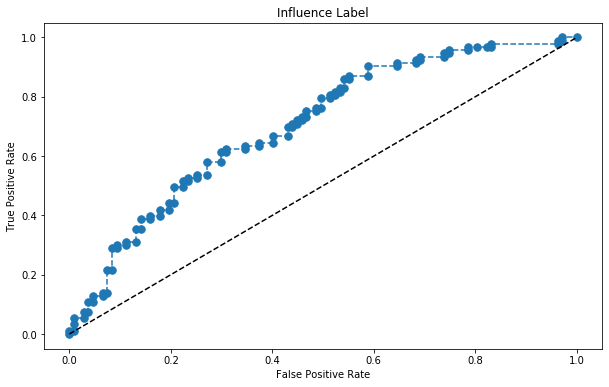

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Logistic: ROC AUC=0.740


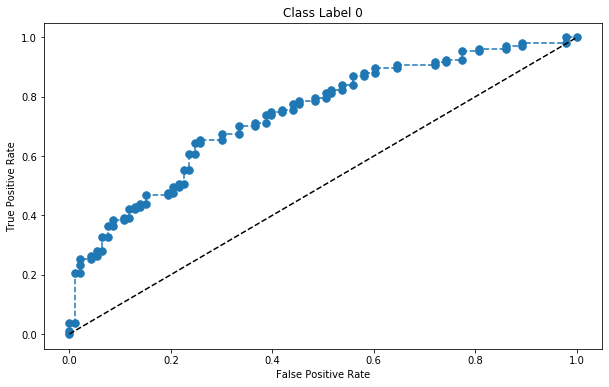

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Logistic: ROC AUC=0.714


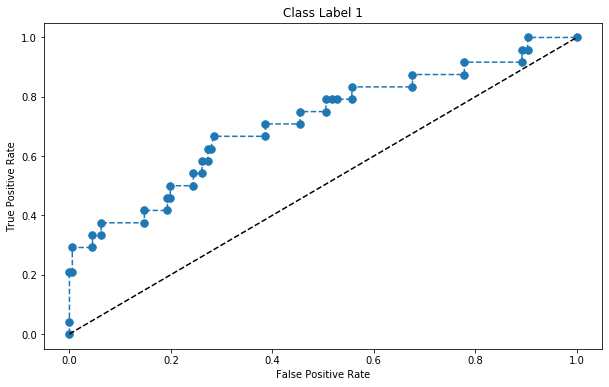

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Logistic: ROC AUC=0.664


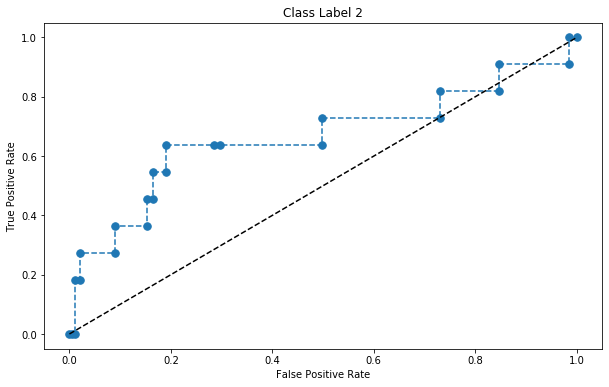

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Logistic: ROC AUC=0.475


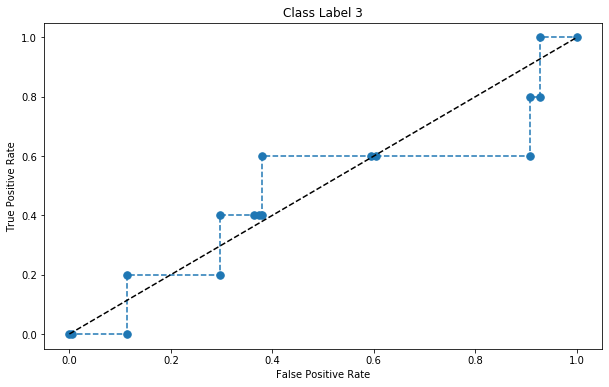

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Logistic: ROC AUC=0.653


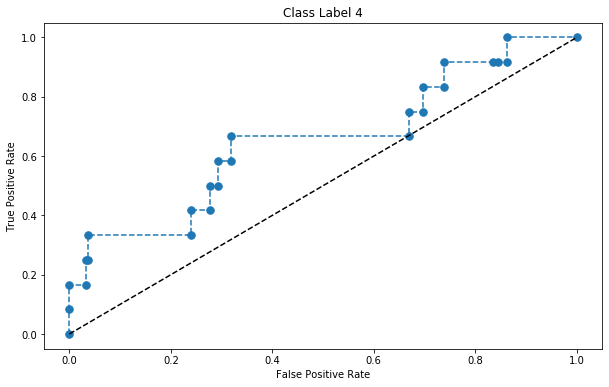

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Logistic: ROC AUC=0.714


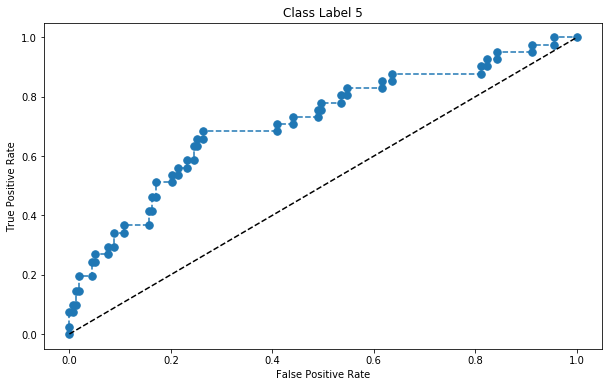

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:17:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Influence F1 score: 0.5813953488372092
[01:17:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:17:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set e

In [37]:
import xgboost as xgb

xgbreg = xgb.XGBClassifier(n_estimators=100, max_depth=3)

rocm(df['embedding'], df['citation_influence_label'], xgbreg)
mmrocm(df['embedding'], df['citation_class_label'], xgbreg)
eval_inf(df['embedding'], df['citation_influence_label'], xgbreg)
eval_class(df['embedding'], df['citation_class_label'], xgbreg)

### Random Forest

Logistic: ROC AUC=0.678


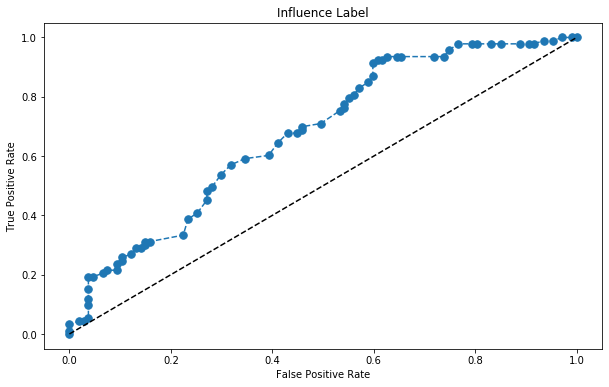

Logistic: ROC AUC=0.770


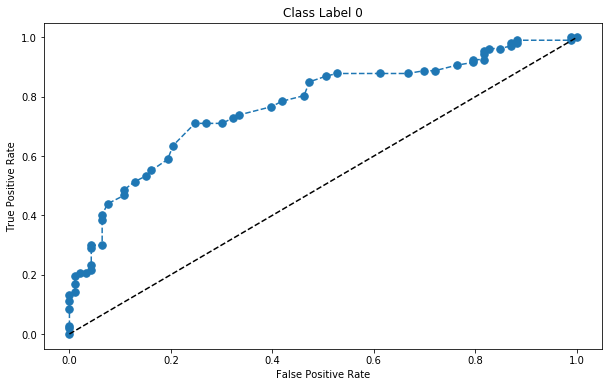

Logistic: ROC AUC=0.722


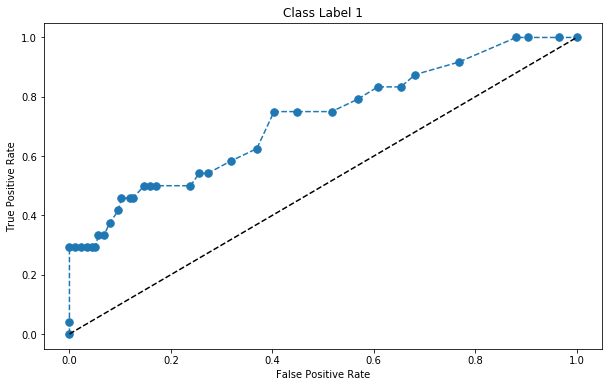

Logistic: ROC AUC=0.520


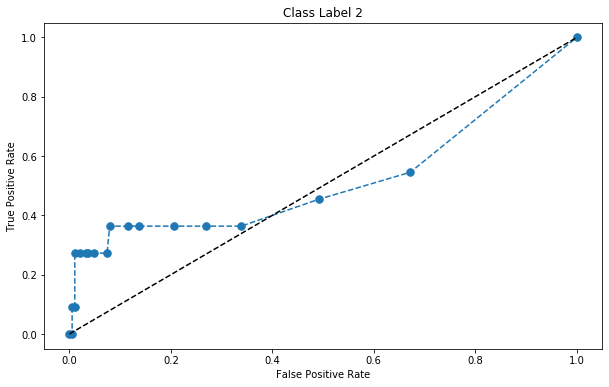

Logistic: ROC AUC=0.582


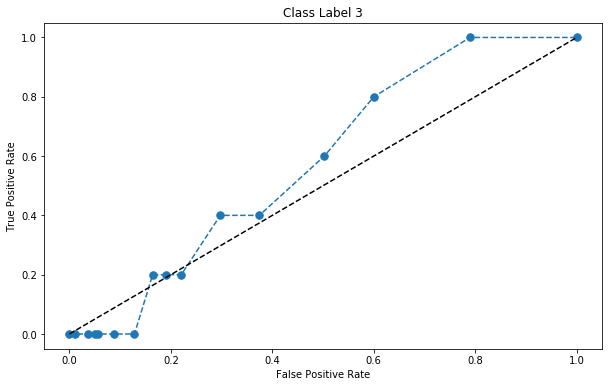

Logistic: ROC AUC=0.589


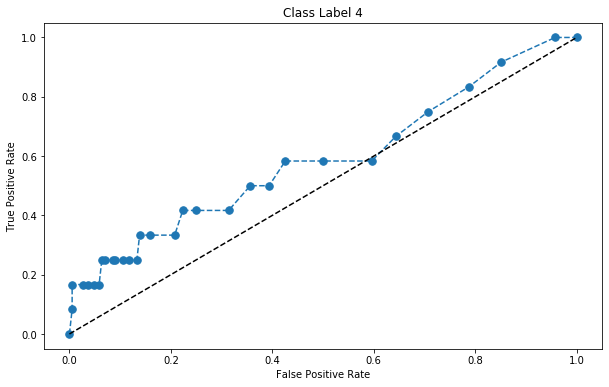

Logistic: ROC AUC=0.692


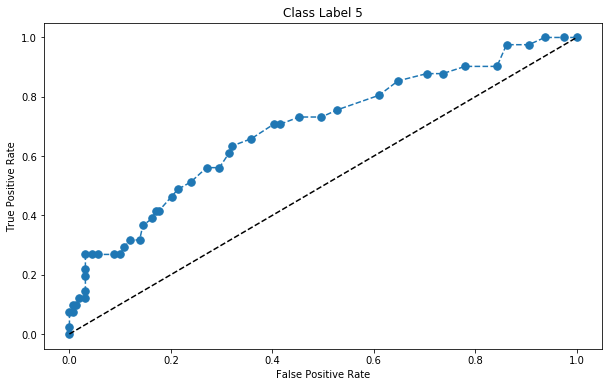

Influence F1 score: 0.48717948717948717
Class F1 score: 0.2997371874032216


In [38]:
from sklearn.ensemble import RandomForestClassifier

rfclf=RandomForestClassifier(n_estimators=100)

rocm(df['embedding'], df['citation_influence_label'], rfclf)
mmrocm(df['embedding'], df['citation_class_label'], rfclf)
eval_inf(df['embedding'], df['citation_influence_label'], rfclf)
eval_class(df['embedding'], df['citation_class_label'], rfclf)

### Smol Neural Network

In [39]:
from torch import nn

input_dim = len(df['embedding'].iloc[0])

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(input_dim, 64)
        # Output layer, 2
        self.output = nn.Linear(64, 2)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)